Extracting the trips

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('cleaned_data.csv',index_col=0)
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

trips = []
trip = []
in_trip = False
for idx, row in df.iterrows():  #trip starts when engine_rpm increases from zero (engine starts) and ends when engine_rpm again reaches zero (engine turns off)
    if row['engine_rpm'] > 0:
        if not in_trip:         #checking if the car was already in trip or not
            in_trip = True      #starting a new trip as car was not in a trip
            trip = []
        trip.append(row)
    elif row['engine_rpm'] == 0:
        if in_trip:             #since there are many zero value, so checking if the car was already in a trip if yes then end the trip
            in_trip = False
            if trip:
                trips.append(pd.DataFrame(trip)) #adding the trip to the trips list


Preparing the trips data

In [2]:
trips_dict = {'trip_start':[],'trip_end':[], 'duration (mins)':[], 'avg_speed':[], 'max_speed':[], 'dist':[], 'MAF':[], 'FAR':[]}
for i in trips:
    trips_dict['trip_start'].append(i.iloc[0]['time_stamp'])
    trips_dict['trip_end'].append(i.iloc[-1]['time_stamp'])
    
    duration = (i.iloc[-1]['time_stamp'] - i.iloc[0]['time_stamp']).total_seconds()
    trips_dict['duration (mins)'].append(duration/60)
        
    trips_dict['avg_speed'].append(i.loc[i['vehicle_speed']!=0, 'vehicle_speed'].mean())
    trips_dict['max_speed'].append(i['vehicle_speed'].max())

    i['time_diff'] = i['time_stamp'].diff().dt.total_seconds()
    i['time_till_speed_continued'] = i['time_diff'].shift(-1)
    i['final_speed'] = i['vehicle_speed'].shift(-1)
    i['acceleration'] = ((i['final_speed']- i['vehicle_speed'])*1000/3600) / i['time_till_speed_continued']
    i['distance'] = round(((i['vehicle_speed']*1000/3600)*i['time_till_speed_continued']) + (0.5*i['acceleration']*(i['time_till_speed_continued']**2)),2)
    

    temp = i.iloc[-1]['vehicle_speed']*1000/3600
    i.at[i.index[-1],'acceleration'] = (0-temp)/2
    i.at[i.index[-1],'distance'] = round(temp*2 + 0.5*((0-temp)/2)*4)

    trips_dict['dist'].append((i['distance'].sum())/1000)


    maf = (i['mass_air_flow_rate'] *i['time_till_speed_continued']).sum() / i['time_till_speed_continued'].sum()
    trips_dict['MAF'].append(maf/1000)
    trips_dict['FAR'].append(i['o_s1_b1_fuel_air_equivalence_ratio'].mean())

trips_df = pd.DataFrame(trips_dict)
trips_df = trips_df.dropna(subset=['avg_speed']).reset_index(drop=True)

Speed Analysis on Trips Data

Number of Trips: 117
Average Speed: 19.41
Maximum Speed: 109.0


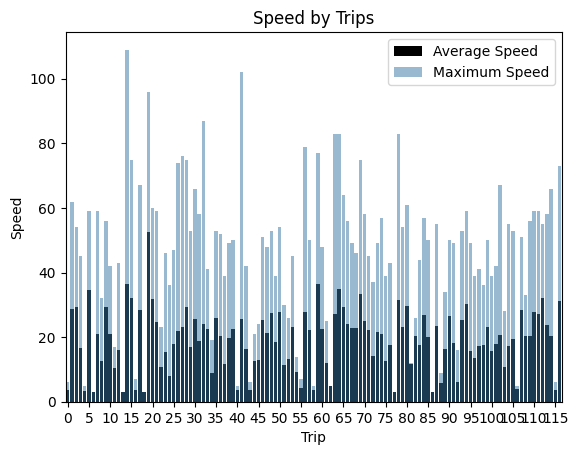

In [3]:
print('Number of Trips:',len(trips_df))
print('Average Speed:',round(trips_df['avg_speed'].mean(),2))
print('Maximum Speed:',trips_df['max_speed'].max())

fig, ax = plt.subplots()
sns.barplot(trips_df, x=trips_df.index, y='avg_speed', ax=ax, label='Average Speed',color='k')
sns.barplot(trips_df, x=trips_df.index, y='max_speed',ax=ax, label='Maximum Speed',alpha=0.5)
ax.set_xticks(ticks=[i for i in range(0,len(trips_df),5)])
ax.set(title='Speed by Trips',xlabel='Trip',ylabel='Speed')
ax.legend()
plt.show()

Fuel Consumption Estimation

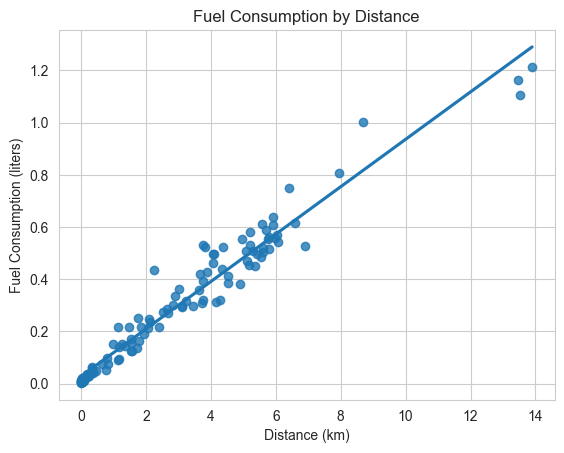

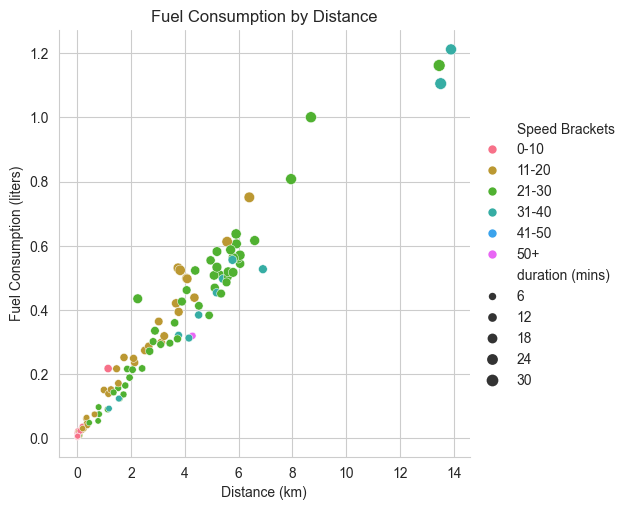

In [4]:
trips_df['fuel_mass_flow_rate'] = trips_df['MAF'] / trips_df['FAR']

trips_df['fuel consumption (kg)'] = trips_df['fuel_mass_flow_rate'] * (trips_df['duration (mins)']*60) #converting to seconds

trips_df['fuel_consumption (liters)'] = trips_df['fuel consumption (kg)'] / 0.75 #density of fuel = 0.75 kg/

speed_labels = ['0-10','11-20','21-30','31-40','41-50','50+']
speed_bins = [0,10,20,30,40,50,np.inf]
trips_df['Speed Brackets'] = pd.cut(trips_df['avg_speed'], bins=speed_bins, labels=speed_labels)


sns.set_style("whitegrid") 
sns.regplot(trips_df, x='dist',y='fuel_consumption (liters)',ci=None).set(title='Fuel Consumption by Distance', \
                        xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
plt.show()
sns.relplot(trips_df, x='dist', y='fuel_consumption (liters)',size='duration (mins)',hue='Speed Brackets',palette='husl') \
                        .set(title='Fuel Consumption by Distance',xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
plt.show()

Acceleration Analysis

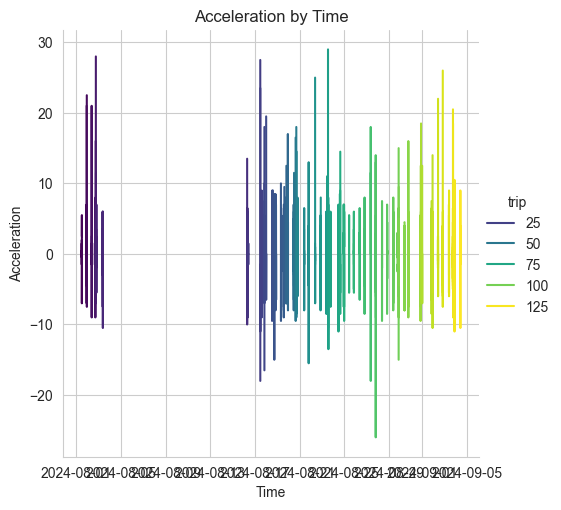

In [5]:
acc_analysis= pd.DataFrame()
for i in range(len(trips)):
    if trips[i]['vehicle_speed'].mean() != 0:
        trips[i]['trip'] = i+1
        acc_analysis = pd.concat([acc_analysis,trips[i]])

acc_analysis['acceleration'] = acc_analysis['acceleration']*3600/1000
sns.relplot(acc_analysis, x='time_stamp',y='acceleration',kind='line',hue='trip',palette='viridis') \
.set(title='Acceleration by Time',xlabel='Time',ylabel='Acceleration')

Looking for Patterns

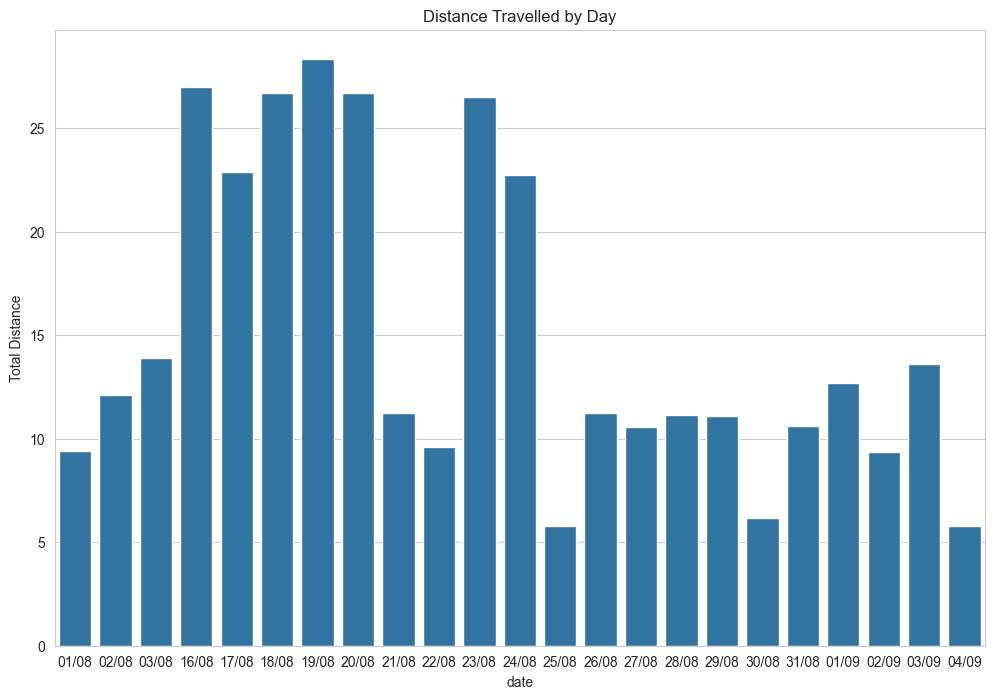

Most Travelled on: 2024-08-19 
Distance: 28.34

Peak Hour
hour           9
trip_count    18
Name: 3, dtype: int64


In [6]:
trips_df['date'] = trips_df['trip_start'].dt.date
total_dist_by_day = trips_df.groupby('date')['dist'].sum().reset_index(name='Total Distance')

total_dist_by_day['date'] = pd.to_datetime(total_dist_by_day['date'])

plt.figure(figsize=(12,8))
sns.barplot(total_dist_by_day, x='date', y='Total Distance').set(title='Distance Travelled by Day')
ticks = total_dist_by_day['date'].dt.strftime('%d/%m')
plt.xticks(ticks=range(len(total_dist_by_day)), labels=ticks)
plt.show()
most_tarvel = total_dist_by_day[total_dist_by_day['Total Distance']==total_dist_by_day['Total Distance'].max()][['date','Total Distance']].values
print('Most Travelled on:',most_tarvel[0][0].date(),'\nDistance:',round(most_tarvel[0][1],2))

trips_df['hour'] = trips_df['trip_start'].dt.hour
peak_times = trips_df.groupby('hour').size().reset_index(name = 'trip_count')
peak_hour = peak_times.loc[peak_times['trip_count'].idxmax()]
print('\nPeak Hour')
print(peak_hour)

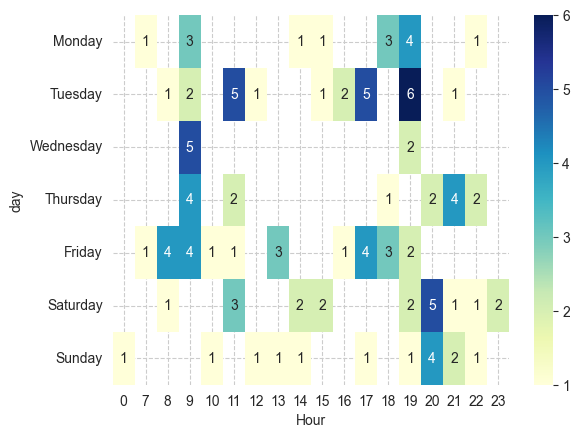

In [7]:
trips_df['day'] = trips_df['trip_start'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_df['day'] = pd.Categorical(trips_df['day'],categories=day_order, ordered=True)

heatmap = trips_df.pivot_table(index='day',columns=trips_df['trip_start'].dt.hour, values='dist', aggfunc='count', observed=True)
# print(heatmap)
sns.heatmap(heatmap, cmap='YlGnBu', annot=True).set(xlabel='Hour')
plt.grid(linestyle='--')
plt.show()

Clustering

C:\Users\Moiz\AppData\Local\Temp\ipykernel_12388\2114812399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.labels_


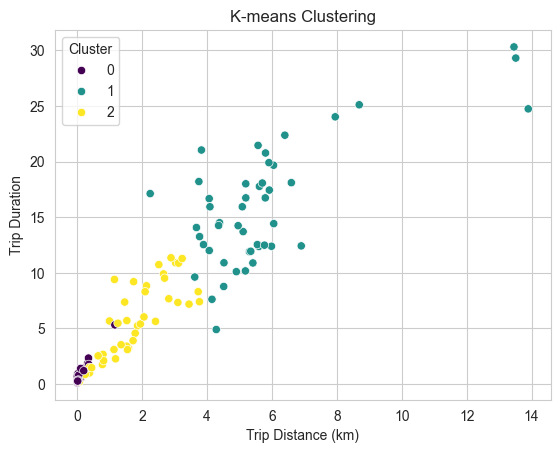

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data = trips_df[['duration (mins)','dist','avg_speed','max_speed','fuel_consumption (liters)']]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=3, random_state=42)  # We choose 3 clusters
kmeans.fit(df_scaled)

data['Cluster'] = kmeans.labels_

sns.scatterplot(data=data, x='dist', y='duration (mins)', hue='Cluster', palette='viridis')
plt.title('K-means Clustering')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration')
plt.show()


C:\Users\Moiz\AppData\Local\Temp\ipykernel_12388\3999008360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = dbscan.labels_


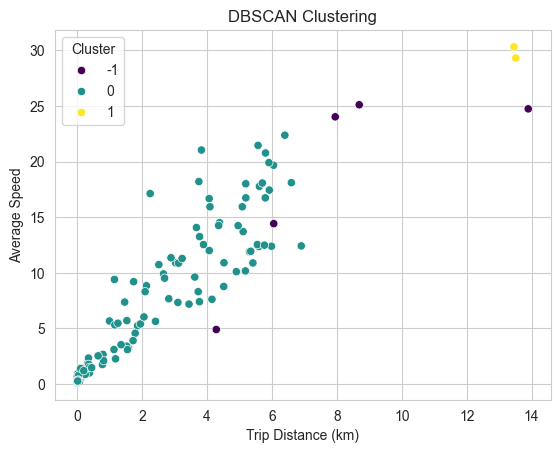

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

df = trips_df[['duration (mins)','dist','avg_speed','max_speed','fuel_consumption (liters)']]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

dbscan = DBSCAN(eps=0.8, min_samples=2)
dbscan.fit(df_scaled)

df['Cluster'] = dbscan.labels_

sns.scatterplot(x='dist', y='duration (mins)', hue='Cluster', palette='viridis', data=df)

plt.title('DBSCAN Clustering')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Average Speed')

plt.show()


C:\Users\Moiz\AppData\Local\Temp\ipykernel_12388\3988643310.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = hc.fit_predict(df_scaled)


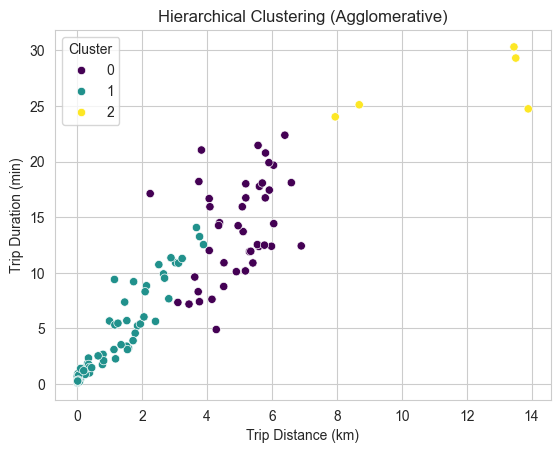

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

df = trips_df[['duration (mins)','dist','avg_speed','max_speed','fuel_consumption (liters)']]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
df['Cluster'] = hc.fit_predict(df_scaled)

sns.scatterplot(x='dist', y='duration (mins)', hue='Cluster', data=df, palette='viridis')
plt.title('Hierarchical Clustering (Agglomerative)')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration (min)')
plt.show()
